# Amazon Bedrock SDK Examples

Amazon Bedrock is a fully managed service that offers a choice of high-performing foundation models (FMs) from leading AI companies like AI21 Labs, Anthropic, Cohere, Meta, Mistral AI, Stability AI, and Amazon via a single API, along with a broad set of capabilities you need to build generative AI applications with security, privacy, and responsible AI.

- Example 1 - Text Generation
- Example 2 - Text Summarization
- Example 3 - Code Generation
- Example 4 - Image Generation

### Required Packages

In [170]:
import boto3
import json
import csv
import sys
import base64
import io
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict

### Setup Bedrock Instance
The **bedrock_runtime** is an instance of AWS Bedrock and has access to bedrock methods such as `invoke_model`

In [171]:
bedrock_runtime = boto3.client('bedrock-runtime', region_name='us-east-1')

### Example 1 - Text Generation
Most user prompts execute Zero-shot, which means you provide no additional examples or details. With zero-shot learning, a pretrained LLM can responsed to effectively to tasks that it hasn’t been specifically trained for.

##### Create Prompt

In [172]:
prompt = "Write a summary of Las Vegas."

##### Create Request Body
Format the request for the `invoke_model` method. **modelId** and **body**.

In [173]:
kwargs = {
    "modelId": "amazon.titan-tg1-large",
    "contentType": "application/json",
    "accept": "*/*",
    "body" : json.dumps(
        {
            "inputText": prompt,
            "textGenerationConfig": {
                "maxTokenCount": 500,
                "temperature": 0.7,
                "topP": 0.9
            }
        }
    )
}

##### Send Request & Print Response
Send the request by calling the `invoke_model` method on the bedrock instance.

In [174]:
response = bedrock_runtime.invoke_model(**kwargs)
response_body = json.loads(response.get('body').read())

generation = response_body['results'][0]['outputText']
print(generation)


Las Vegas is a resort city in Nevada, famous for its gambling, shopping, entertainment, and nightlife. It is located in the Mojave Desert and is known for its luxurious casinos, hotels, and restaurants. Las Vegas is also a popular destination for conventions and conferences, with many of the world's largest hotels and convention centers located there. The city has a rich history, with its roots dating back to the 19th century when it was a small mining town. Today, Las Vegas is a global hub for tourism and entertainment, attracting millions of visitors each year.


### Example 2 - Summarize Audio Transcript
Using Amazon Bedrock to summarize longer text. Summarization works by sending a prompt instruction to the model.

##### Load Audio File Context
The transcript of the audio file has been downloaded and saved as transcript.txt.

In [175]:
with open('../assets/transcript.txt', "r") as file:
    dialogue_text = file.read()

##### Create Prompt
In this example, we place the file transcript within the tag <transcript></transcript>. This allows us to format the instructions for the model.

In [176]:
prompt = f"""The text between the <transcript> XML tags is a transcript of a conversation. 
Write a short summary of the conversation.

<transcript>
{dialogue_text}
</transcript>

Here is a summary of the conversation in the transcript:"""

In [177]:
print(prompt)

The text between the <transcript> XML tags is a transcript of a conversation. 
Write a short summary of the conversation.

<transcript>
spk_0: Hi, is this the Crystal Heights Hotel in Singapore? 
spk_1: Yes, it is. Good afternoon. How may I assist you today? 
spk_0: Fantastic, good afternoon. I was looking to book a room for my 10th wedding anniversary. Ive heard your hotel offers exceptional views and services. Could you tell me more? 
spk_1: Absolutely, Alex and congratulations on your upcoming anniversary. Thats a significant milestone and wed be honored to make it a special occasion for you. We have several room types that offer stunning views of the city skyline and the fictional Sapphire Bay. Our special diamond suite even comes with exclusive access to the moonlit pool and star deck. We also have in house spa services, world class dining options and a shopping arcade. 
spk_0: That sounds heavenly. I think my spouse would love the moonlit pool. Can you help me make a reservation 

##### Create Request Body

In [178]:
kwargs = {
    "modelId": "amazon.titan-tg1-large",
    "contentType": "application/json",
    "accept": "*/*",
    "body": json.dumps(
        {
            "inputText": prompt,
            "textGenerationConfig": {
                "maxTokenCount": 512,
                "temperature": 0,
                "topP": 0.9
            }
        }
    )
}

##### Send Request & Print Response

In [179]:
response = bedrock_runtime.invoke_model(**kwargs)

In [180]:
response_body = json.loads(response.get('body').read())
generation = response_body['results'][0]['outputText']
print(generation)


Alex is looking to book a room for his 10th wedding anniversary at the Crystal Heights Hotel in Singapore. The hotel offers several room types that offer stunning views of the city skyline and the fictional Sapphire Bay. The special diamond suite even comes with exclusive access to the moonlit pool and star deck. The package includes breakfast, complimentary access to the moonlit pool and star deck, a one-time spa treatment for two, and a special romantic dinner at the cloud nine restaurant. A preauthorization amount of $1000 will be held on the card, which will be released upon checkout. There is a 10% service charge and a 7% fantasy tax applied to the room rate.


### Example 3 - Code Generation
We can also use AWS Bedrock to generate code to solve business problems.

##### Create Sales Data

In [181]:
data = [
    ["date", "product_id", "price", "units_sold"],
    ["2023-01-01", "P001", 50, 20],
    ["2023-01-02", "P002", 60, 15],
    ["2023-01-03", "P001", 50, 18],
    ["2023-01-04", "P003", 70, 30],
    ["2023-01-05", "P001", 50, 25],
    ["2023-01-06", "P002", 60, 22],
    ["2023-01-07", "P003", 70, 24],
    ["2023-01-08", "P001", 50, 28],
    ["2023-01-09", "P002", 60, 17],
    ["2023-01-10", "P003", 70, 29],
    ["2023-02-11", "P001", 50, 23],
    ["2023-02-12", "P002", 60, 19],
    ["2023-02-13", "P001", 50, 21],
    ["2023-02-14", "P003", 70, 31],
    ["2023-03-15", "P001", 50, 26],
    ["2023-03-16", "P002", 60, 20],
    ["2023-03-17", "P003", 70, 33],
    ["2023-04-18", "P001", 50, 27],
    ["2023-04-19", "P002", 60, 18],
    ["2023-04-20", "P003", 70, 32],
    ["2023-04-21", "P001", 50, 22],
    ["2023-04-22", "P002", 60, 16],
    ["2023-04-23", "P003", 70, 34],
    ["2023-05-24", "P001", 50, 24],
    ["2023-05-25", "P002", 60, 21]
]

##### Write Data To CSV File

In [182]:
# Write data to sales.csv
with open('sales.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)

print("sales.csv has been created!")

sales.csv has been created!


##### Create Prompt

In [183]:
prompt_data = """

Human: You have a CSV, sales.csv, with columns:
- date (YYYY-MM-DD)
- product_id
- price
- units_sold

Create a python program to analyze the sales data from a CSV file. The program should be able to read the data, and determine below:

- Total revenue for the year
- The product with the highest revenue
- The date with the highest revenue
- Visualize monthly sales using a bar chart

Ensure the code is syntactically correct, bug-free, optimized, do not span multiple lines unnessarily, and prefer to use standard libraries. If using the python pandas library then use the pandas object whn calling the plot method. Example: `pd.plot()`. Return only python code without any surrounding text, explanation or context.

Assistant:
"""

##### Prepare Prompt For Request

In [184]:
body = json.dumps({
                    "prompt": prompt_data,
                    "max_tokens_to_sample":4096,
                    "temperature":0.5,
                    "top_k":250,
                    "top_p":0.5,
                    "stop_sequences": ["\n\nHuman:"]
                  }) 

##### Create Request Body

In [185]:
kwargs = {
    "modelId": "amazon.titan-tg1-large",
    "contentType": "application/json",
    "accept": "*/*",
    "body": json.dumps(
        {
            "inputText": body,
            "textGenerationConfig": {
                "maxTokenCount": 512,
                "temperature": 0,
                "topP": 0.9
            }
        }
    )
}

##### Send Request & Print Response

In [186]:
response = bedrock_runtime.invoke_model(**kwargs)

In [187]:
response_body = json.loads(response.get('body').read())
generation = response_body['results'][0]['outputText']
print(generation)


import pandas as pd

# Read the CSV file and store it in a DataFrame
df = pd.read_csv('sales.csv')

# Calculate the total revenue for the year
total_revenue = df['price'].sum()

# Determine the product with the highest revenue
highest_revenue_product = df['product_id'].max()

# Determine the date with the highest revenue
highest_revenue_date = df['date'].max()

# Visualize monthly sales using a bar chart
df.plot(kind='bar')

# Display the results
print("Total Revenue:", total_revenue)
print("Product with the Highest Revenue:", highest_revenue_product)
print("Date with the Highest Revenue:", highest_revenue_date)



##### Run Code

Total Revenue: 1470
Product with the Highest Revenue: P003
Date with the Highest Revenue: 2023-05-25


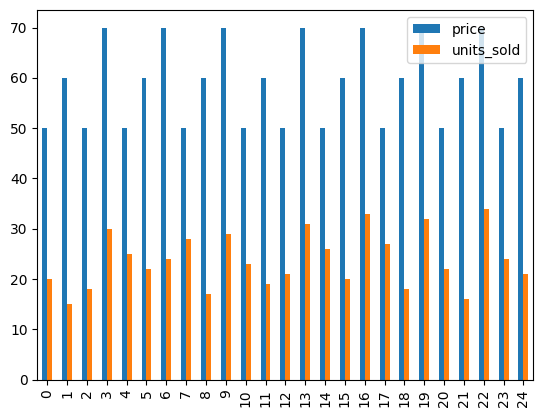

In [188]:
import pandas as pd

# Read the CSV file and store it in a DataFrame
df = pd.read_csv('sales.csv')

# Calculate the total revenue for the year
total_revenue = df['price'].sum()

# Determine the product with the highest revenue
highest_revenue_product = df['product_id'].max()

# Determine the date with the highest revenue
highest_revenue_date = df['date'].max()

# Visualize monthly sales using a bar chart
df.plot(kind='bar')

# Display the results
print("Total Revenue:", total_revenue)
print("Product with the Highest Revenue:", highest_revenue_product)
print("Date with the Highest Revenue:", highest_revenue_date)

### Image Generation

In [189]:
prompt_data = "The city cafe."

In [190]:
body=json.dumps({
    "text_prompts": [
        {
          "text": prompt_data
        }
    ],
        "cfg_scale": 10,
        "seed": 0,
        "steps": 50,
        "samples" : 1,
        "style_preset" : "photographic"
})

In [191]:
kwargs = {
    "modelId": "stability.stable-diffusion-xl-v1",
    "contentType": "application/json",
    "accept": "*/*",
    "body": body
}

In [192]:
response = bedrock_runtime.invoke_model(**kwargs)
response_body = json.loads(response.get("body").read())
print(response_body['result'])

success


In [193]:
base64_image = response_body.get("artifacts")[0].get("base64")
base64_bytes = base64_image.encode('ascii')
image_bytes = base64.b64decode(base64_bytes)

finish_reason = response_body.get("artifacts")[0].get("finishReason")

if finish_reason == 'ERROR' or finish_reason == 'CONTENT_FILTERED':
    raise ImageError(f"Image generation error. Error code is {finish_reason}")

image = Image.open(io.BytesIO(image_bytes))
image.show()

### References

[AWS Skill Builder](https://explore.skillbuilder.aws/learn)

[Pretained Models](https://docs.aws.amazon.com/bedrock/latest/userguide/models-supported.html)